# Import Libraries

#### Modeling and Modeling Metrics Libraries 

In [1]:
# Models and Transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

# Model Metrics
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, f1_score
from sklearn import metrics

# Optimization
from sklearn.model_selection import GridSearchCV

#### Data Visualization

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### File Management

In [2]:
import os
import subprocess
import glob

import json
import csv

#### NLP & Text Parsing

In [3]:
import re
from textblob import TextBlob

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#### Pandas/NumPy/Datetime

In [6]:
import pandas as pd
import numpy as np

from datetime import datetime, date, time

#### Twitter/Stock Data Scraper

In [7]:
import snscrape.modules.twitter as sntwitter
import yfinance as yf

# Custom Functions

In [8]:
# Get Twitter Data (Saved as csv on local machine)

def scrapeTweets(start_date, end_date, keyword, current_dir, tweet_limit=1, iteration=0):
    if not os.path.exists(current_dir):  # Creates directory in current directory if doesn't already exist
        os.mkdir(current_dir)

    file_path = os.path.join(current_dir, f'keyword:{keyword}__start:{start_date}_end:{end_date}__iter:{iteration}.csv')

    tweet_list = []
    for i, tweet in enumerate(
            sntwitter.TwitterSearchScraper(f'{keyword} since:{start_date} until:{end_date}').get_items()):
        if i > tweet_limit:
            break
        tweet_list.append([tweet.date,  # Appending all tweet data into a list of list
                           tweet.id,
                           tweet.content,
                           tweet.user.username,
                           tweet.user.followersCount,
                           tweet.lang,
                           tweet.retweetCount,
                           tweet.likeCount,
                           tweet.replyCount])

    df_tweets = pd.DataFrame(tweet_list, columns=['Datetime',  # Creating df of tweet data
                                                  'Tweet Id',
                                                  'Text',
                                                  'Username',
                                                  'Followers Count',
                                                  'Language',
                                                  'Retweet Count',
                                                  'Likes Count',
                                                  'Reply Count'])

    for i in range(1001):
        if not os.path.isfile(file_path):
            df_tweets.to_csv(file_path, index=False)
            break
        else:
            file_path = os.path.join(current_dir,
                                     f'keyword:{keyword}__start:{start_date}_end:{end_date}__limit:{tweet_limit}__iter:{i + 1}.csv')

    if os.path.isfile(file_path):
        return print(f'Successfully saved DataFrame to {file_path}')
    return print('DataFrame not saved -- possible error has occurred.')

In [9]:
def dataWrangle_single(dataframe):   
    df_filter = dataframe[dataframe['Language'] == 'en'][['Datetime', # Filter via Language = 'en'
                                                           'Tweet Id', # Remove unwanted columns
                                                           'Text', 
                                                           'Username',
                                                           'Followers Count',
                                                           'Retweet Count',
                                                           'Likes Count',
                                                           'Reply Count']] 
    df_clean = df_filter.astype({'Tweet Id':str})\
                        .dropna()\
                        .drop_duplicates()\
                        .reset_index(drop=True)
    
    df_clean['Text'] = (df_clean['Text'] # Cleans out redundant string characters within each tweet
                       .apply(lambda x: ' '.join(re.sub(r'https\S+', '', x)
                                                .replace('\n', ' ')
                                                .split()
                                                )
                             )
                       )
    
    df_clean['Datetime'] = pd.to_datetime(df_clean['Datetime']).dt.floor('d').dt.tz_localize(tz=None)
    
    return df_clean.set_index('Datetime').sort_index()

In [10]:
# Wrangle Tweet Data

def dataWrangle_multiple(dataframe_list):   
    df_concat = pd.concat(dataframe_list) # Concatenate all the DataFrames from the list of DataFrames
    df_filter = df_concat[df_concat['Language'] == 'en'][['Datetime', # Filter via Language = 'en'
                                                           'Tweet Id', # Remove unwanted columns
                                                           'Text', 
                                                           'Username',
                                                           'Followers Count',
                                                           'Retweet Count',
                                                           'Likes Count',
                                                           'Reply Count']] 
    df_clean = df_filter.astype({'Tweet Id':str})\
                        .dropna()\
                        .drop_duplicates()\
                        .reset_index(drop=True)
    
    df_clean['Text'] = (df_clean['Text'] # Cleans out redundant string characters within each tweet
                       .apply(lambda x: ' '.join(re.sub(r'https\S+', '', x)
                                                .replace('\n', ' ')
                                                .split()
                                                )
                             )
                       )
    
    df_clean['Datetime'] = pd.to_datetime(df_clean['Datetime']).dt.floor('d').dt.tz_localize(tz=None)
    
    return df_clean.set_index('Datetime').sort_index()
                                               

In [11]:
# Get Stock Data (DataFrame)

def getStockData(ticker, start, end):
    df_stock = yf.download(ticker, start, end)
    df_stock.index = df_stock.index.tz_localize(tz=None).rename(name='Datetime')
    df_stock['Closing Differences'] = df_stock['Adj Close'].diff()
    df_stock['Percent Change'] = ((df_stock['Close']-df_stock['Open'])/df_stock['Open'])*100
    
    return df_stock    

In [12]:
# CLASSIFICATION Model Evaluation

def model_evaluation(model, X, y_true, positive_label):
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y_true, y_pred, pos_label=positive_label), 4)
    scores['recall'] = round(metrics.recall_score(y_true, y_pred, pos_label=positive_label), 4)
    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_true, probs, pos_label=positive_label)
    scores['area under precision-recall curve'] = round(metrics.auc(recalls, precisions), 4)
    scores['f1 score'] = round(f1_score(y_true=y_true, y_pred=y_pred, pos_label= "Positive_Trend"), 4)
    return scores

def print_model_evaluation(model_name, scores):
#     print('{} evaluation \n'.format(model_name))
    for metric, score in scores.items():
        print('Test {}: {}'.format(metric, score))


In [13]:
# 1. Polarity Score Categories as a column on DataFrame
# 2. Creating categorical polarity column

def polarityCategories_textblob(tup):
    if tup[0] < -0.05:
        return 'Negative'
    elif tup[0] > 0.05:
        return 'Positive'
    else:
        return 'Neutral'
    
def polarityColumns_textblob(df_tweets):
    df_tweets['Polarity/Subjectivity Scores'] = df_tweets['Text'].apply(lambda text: TextBlob(text).sentiment)
    df_tweets_filtered = df_tweets[df_tweets['Polarity/Subjectivity Scores'] != (0.0,0.0)]
    df_tweets_filtered = df_tweets_filtered.copy()
    df_tweets_filtered['Polarity Categories'] = df_tweets_filtered['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories(x))
    
    print(df_tweets_filtered.value_counts('Polarity Categories'))
    
    return df_tweets_filtered

In [14]:
def polarityCategories_vader(tup):
    if tup[0] < -0.05:
        return 'Negative'
    elif tup[0] > 0.05:
        return 'Positive'
    else:
        return 'Neutral'
    
def polarityColumns_vader(df_tweets):
    df_tweets['Sentiment'] = df_tweets['Text'].apply(lambda text: SentimentIntensityAnalyzer().polarity_scores(text))
#     df_tweets_filtered = df_tweets_filtered.copy()
#     df_tweets_filtered['Polarity Categories'] = df_tweets_filtered['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories_vader(x))
    
#     print(df_tweets_filtered.value_counts('Polarity Categories'))
    
    return df_tweets

In [15]:
def assign_score_columns(df):
    df['Positive Tweet Score'] = df['Sentiment_todict'].apply(lambda scores: scores['pos'])
    df['Negative Tweet Score'] = df['Sentiment_todict'].apply(lambda scores: scores['neg'])
    df['Neutral Tweet Score'] = df['Sentiment_todict'].apply(lambda scores: scores['neu'])
    df['Compound Tweet Score'] = df['Sentiment_todict'].apply(lambda scores: scores['compound'])
    
    df = df[df['Compound Tweet Score'] != 0.0]
    return df

# Twitter Data

## GME Tweets

In [ ]:
start_time = date(2021, 1, 8).strftime('%Y-%m-%d')
stop_time = date(2021, 2, 12).strftime('%Y-%m-%d')

In [13]:
# Creating a list of DataFrames using glob's list of files names
df_tweet_gme_list = []
for i in glob.glob('01-23_tweet/*'):
    df_tweet_gme_list.append(pd.read_csv(i))

In [24]:
df_tweet_GME = pd.read_csv('tweets_GME_01-01--06-30\\df_GME_incomplete.csv')

In [ ]:
df_tweet_gme = pd.read_csv()

In [25]:
df_tweet_gme = dataWrangle_single(df_tweet_GME)

# Polarity Scores

In [16]:
from ast import literal_eval

In [61]:
df_tweet_gme = pd.read_csv('df_tweet_gme_VADER_SENTIMENT.csv')

In [62]:
df_tweet_gme['Datetime'] = pd.to_datetime(df_tweet_gme['Datetime']).dt.floor('d').dt.tz_localize(tz=None)

In [63]:
df_tweet_gme = df_tweet_gme.set_index('Datetime')

In [64]:
df_tweet_gme['Sentiment_todict'] = df_tweet_gme['Sentiment'].apply(lambda string: literal_eval(string))

In [65]:
df_tweet_gme = assign_score_columns(df_tweet_gme)

In [66]:
df_tweet_gme = df_tweet_gme[df_tweet_gme['Compound Tweet Score'] != 0.0]

In [67]:
df_tweet_gme = df_tweet_gme.copy()
df_tweet_gme['Compound Followers'] = df_tweet_gme['Compound Tweet Score'] * df_tweet_gme['Followers Count']

In [180]:
# Consider removing these rows to improve model

df_tweet_gme[df_tweet_gme['Compound Followers'] == 0.0]

,Tweet Id,Text,Username,Followers Count,Retweet Count,Likes Count,Reply Count,Sentiment,Sentiment_todict,Positive Tweet Score,Negative Tweet Score,Neutral Tweet Score,Compound Tweet Score,Compound Followers
Datetime,,,,,,,,,,,,,,
2021-01-01,1345072021772914691,@Flyin111 @potatolord312 @AustinJohnPlays That...,DrnknSailr,0,0,1,0,"{'neg': 0.177, 'neu': 0.738, 'pos': 0.085, 'co...","{'neg': 0.177, 'neu': 0.738, 'pos': 0.085, 'co...",0.085,0.177,0.738,-0.7579,-0.0
2021-01-01,1344839675161292800,@PS5StockUpdates My GameStop order from the 18...,HarleyN63118083,0,0,0,0,"{'neg': 0.182, 'neu': 0.818, 'pos': 0.0, 'comp...","{'neg': 0.182, 'neu': 0.818, 'pos': 0.0, 'comp...",0.000,0.182,0.818,-0.2500,-0.0
2021-01-01,1345049260543389701,@GameStop yo what kind of bullshit r u guys pr...,Boinkbonk2,0,0,0,0,"{'neg': 0.252, 'neu': 0.665, 'pos': 0.083, 'co...","{'neg': 0.252, 'neu': 0.665, 'pos': 0.083, 'co...",0.083,0.252,0.665,-0.7264,-0.0
2021-01-01,1345094349168771077,@PopFindr Just snagged one from GameStop thank...,lyon9211,0,0,0,0,"{'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'comp...","{'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'comp...",0.303,0.000,0.697,0.5399,0.0
2021-01-01,1345107323040264192,@LindseySzakacs @spieltimes @GameStop @spielti...,OmgItsLexieDee,0,0,0,0,"{'neg': 0.096, 'neu': 0.777, 'pos': 0.128, 'co...","{'neg': 0.096, 'neu': 0.777, 'pos': 0.128, 'co...",0.128,0.096,0.777,0.1759,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,1410349911627997187,@GameStop can you please bring “pogs” back??🙏🏼...,brendon22971491,0,0,0,0,"{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp...","{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp...",0.206,0.000,0.794,0.7932,0.0
2021-06-30,1410380631909928960,@mattswider My friend has had his ps5 for 6 mo...,JosephN18372375,0,0,0,0,"{'neg': 0.0, 'neu': 0.831, 'pos': 0.169, 'comp...","{'neg': 0.0, 'neu': 0.831, 'pos': 0.169, 'comp...",0.169,0.000,0.831,0.7096,0.0
2021-06-30,1410383823217463297,@GameStopHelp I’m using Chrome on iPhone XS an...,tuhoang07,0,0,0,1,"{'neg': 0.067, 'neu': 0.933, 'pos': 0.0, 'comp...","{'neg': 0.067, 'neu': 0.933, 'pos': 0.0, 'comp...",0.000,0.067,0.933,-0.2500,-0.0


In [ ]:
# Try using SMOTE on Polarity scores

# Aggregation

In [69]:
df_tweet_gme_dailymean = df_tweet_gme.groupby('Datetime').mean()

In [70]:
pd.set_option("display.max_rows", 90)

In [71]:
df_tweet_gme_dailymean

,Tweet Id,Followers Count,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Negative Tweet Score,Neutral Tweet Score,Compound Tweet Score,Compound Followers
Datetime,,,,,,,,,,
2021-01-01,1.344979e+18,62086.130963,0.949696,10.635733,1.125759,0.160056,0.062647,0.777298,0.269853,34364.360617
2021-01-02,1.345359e+18,101770.186290,68.192742,57.750000,3.098387,0.161263,0.052595,0.786141,0.327639,44249.406987
2021-01-03,1.345734e+18,101301.291471,1.685695,25.027535,2.658831,0.156467,0.064760,0.778779,0.273965,25993.188582
2021-01-04,1.346104e+18,93561.129870,1.246163,15.107438,2.065525,0.149979,0.058672,0.791347,0.258476,40531.963996
2021-01-05,1.346466e+18,29511.414783,0.873913,9.100870,0.984348,0.162212,0.057242,0.780561,0.313195,8266.200468
...,...,...,...,...,...,...,...,...,...,...
2021-06-26,1.408885e+18,243348.953474,4.097281,45.287009,3.056193,0.162093,0.072709,0.765185,0.295099,143663.299006
2021-06-27,1.409257e+18,233403.859638,28.293200,299.946974,7.606363,0.152480,0.071153,0.776387,0.225888,73539.994403
2021-06-28,1.409620e+18,405717.609408,2.689218,23.022199,1.616808,0.177967,0.069434,0.752597,0.320421,193374.560155


In [1]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_tweet_gme_dailymean['Positive Tweet Score'])
plt.xlabel('Lag (days)');
plt.axvline(31, color = 'green')

NameError: name 'df_tweet_gme_dailymean' is not defined

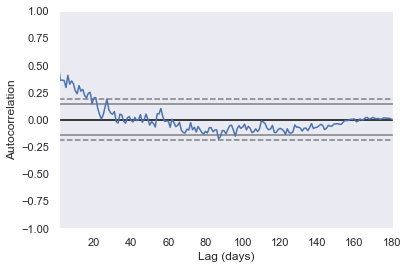

In [37]:
autocorrelation_plot(df_tweet_gme_dailymean['Negative Tweet Score'])
plt.xlabel('Lag (days)');

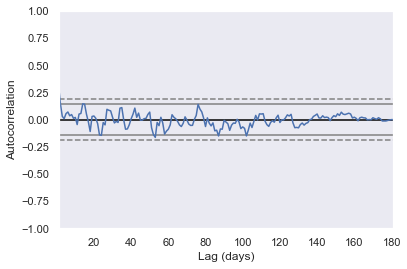

In [38]:
autocorrelation_plot(df_tweet_gme_dailymean['Neutral Tweet Score'])
plt.xlabel('Lag (days)');

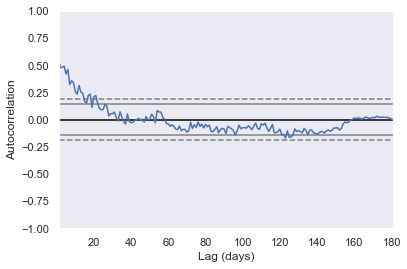

In [39]:
autocorrelation_plot(df_tweet_gme_dailymean['Compound Tweet Score'])
plt.xlabel('Lag (days)');

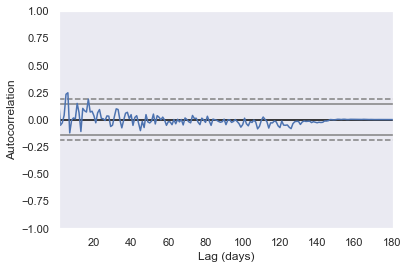

In [40]:
autocorrelation_plot(df_tweet_gme_dailymean['Compound Followers'])
plt.xlabel('Lag (days)');

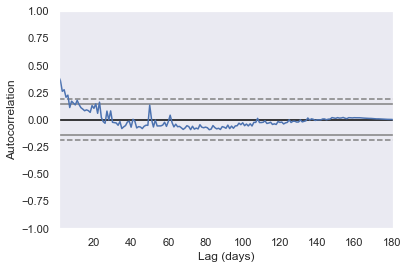

In [41]:
autocorrelation_plot(df_tweet_gme_dailymean['Followers Count'])
plt.xlabel('Lag (days)');

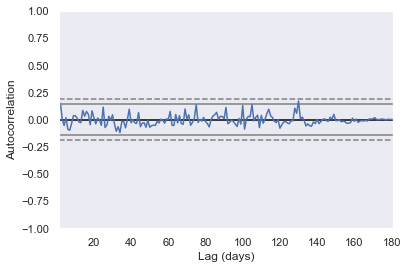

In [42]:
autocorrelation_plot(df_tweet_gme_dailymean['Reply Count'])
plt.xlabel('Lag (days)');

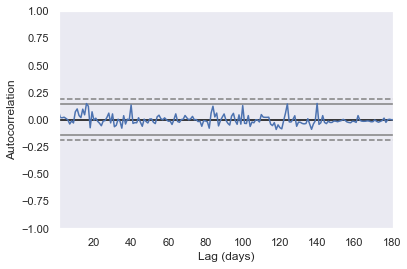

In [43]:
autocorrelation_plot(df_tweet_gme_dailymean['Likes Count'])
plt.xlabel('Lag (days)');

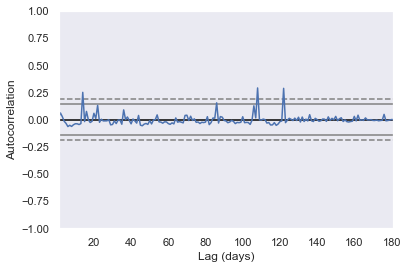

In [44]:
autocorrelation_plot(df_tweet_gme_dailymean['Retweet Count'])
plt.xlabel('Lag (days)');

# Stock Data

## GME

In [72]:
df_stock_gme = getStockData('GME','2021-01-01','2021-06-30')

[*********************100%***********************]  1 of 1 completed


In [73]:
df_stock_gme

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,Percent Change
Datetime,,,,,,,,
2021-01-04,19.000000,19.100000,17.150000,17.250000,17.250000,10022500,NaN,-9.210526
2021-01-05,17.350000,18.080000,17.230000,17.370001,17.370001,4961500,0.120001,0.115276
2021-01-06,17.340000,18.980000,17.330000,18.360001,18.360001,6056200,0.990000,5.882356
2021-01-07,18.469999,19.450001,18.020000,18.080000,18.080000,6129300,-0.280001,-2.111529
2021-01-08,18.180000,18.299999,17.080000,17.690001,17.690001,6482000,-0.389999,-2.695268
...,...,...,...,...,...,...,...,...
2021-06-23,221.449997,222.570007,214.119995,219.339996,219.339996,3555100,-1.059998,-0.952811
2021-06-24,221.160004,227.449997,211.600006,212.309998,212.309998,3863300,-7.029999,-4.001630
2021-06-25,214.000000,214.199997,198.500000,209.509995,209.509995,12692700,-2.800003,-2.098133


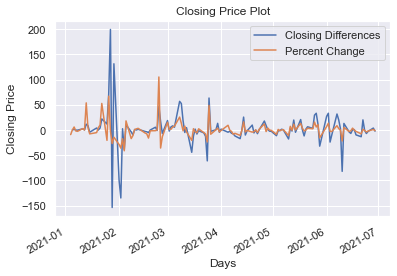

In [74]:
# Plot

df_stock_gme[['Closing Differences', 'Percent Change']].plot()

# plt.ylim(-120, 120)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

## AAPL

In [89]:
df_stock_aapl = getStockData('AAPL', '2021-01-01', '2021-03-01')

[*********************100%***********************]  1 of 1 completed


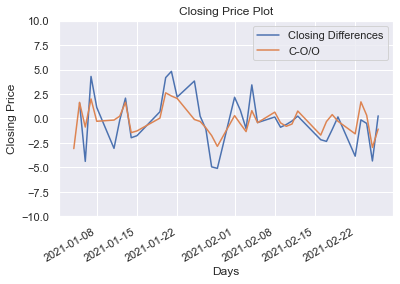

In [96]:
# Plot

df_stock_aapl[['Closing Differences', 'C-O/O']].plot()

plt.ylim(-10, 10)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

# Merging Twitter + Stock DataFrames

## GME

In [131]:
# Why is there NaN values for Volume and closing differences?
# Because the stock market is only opened on business days!
# So we dropped NaN values

df_merged_gme = df_stock_gme.merge(df_tweet_gme_dailymean, how='right', left_index=True, right_index=True)

In [140]:
df_merged_gme['Percent Change Trend'] = df_merged_gme['Percent Change'].apply(lambda x: "Positive_Trend" if x>=0 else "Negative_Trend")
df_merged_gme['Closing Price Trend'] = df_merged_gme['Closing Differences'].apply(lambda x: "Positive_Trend" if x>=0 else "Negative_Trend")

C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/1505532162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme['Percent Change Trend'] = df_merged_gme['Percent Change'].apply(lambda x: "Positive_Trend" if x>=0 else "Negative_Trend")
C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/1505532162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme['Closing Price Trend'] = df_merged_gme['Closing Differences'].apply(lambda x: "Positive_Trend" if x>=0 else "Negative_Trend")


In [134]:
df_merged_gme = df_merged_gme[['Volume', 'Closing Differences', 'Percent Change', 'Tweet Id', 'Followers Count', 'Retweet Count',
                 'Likes Count', 'Reply Count', 'Positive Tweet Score', 'Neutral Tweet Score','Negative Tweet Score', 'Compound Tweet Score',
                  'Compound Followers', 'Percent Change Trend', 'Closing Price Trend']]

In [83]:
# fill NA with mean

df_merged_gme['Volume'].fillna(df_merged_gme['Volume'].mean(), inplace=True)
df_merged_gme['Closing Differences'].fillna(df_merged_gme['Closing Differences'].mean(), inplace=True)
df_merged_gme['Percent Change'].fillna(df_merged_gme['Percent Change'].mean(), inplace=True)

In [139]:
df_merged_gme

,Volume,Closing Differences,Percent Change,Tweet Id,Followers Count,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Neutral Tweet Score,Negative Tweet Score,Compound Tweet Score,Compound Followers,Percent Change Trend,Closing Price Trend
Datetime,,,,,,,,,,,,,,,
2021-01-01,1.002250e+07,0.120001,-9.210526,1.344979e+18,62086.130963,0.949696,10.635733,1.125759,0.160056,0.777298,0.062647,0.269853,34364.360617,Negative_Trend,Negative_Trend
2021-01-02,1.002250e+07,0.120001,-9.210526,1.345359e+18,101770.186290,68.192742,57.750000,3.098387,0.161263,0.786141,0.052595,0.327639,44249.406987,Negative_Trend,Negative_Trend
2021-01-03,1.002250e+07,0.120001,-9.210526,1.345734e+18,101301.291471,1.685695,25.027535,2.658831,0.156467,0.778779,0.064760,0.273965,25993.188582,Negative_Trend,Negative_Trend
2021-01-04,1.002250e+07,0.120001,-9.210526,1.346104e+18,93561.129870,1.246163,15.107438,2.065525,0.149979,0.791347,0.058672,0.258476,40531.963996,Negative_Trend,Negative_Trend
2021-01-05,4.961500e+06,0.120001,0.115276,1.346466e+18,29511.414783,0.873913,9.100870,0.984348,0.162212,0.780561,0.057242,0.313195,8266.200468,Positive_Trend,Positive_Trend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,1.008827e+07,-0.620000,-1.083174,1.408885e+18,243348.953474,4.097281,45.287009,3.056193,0.162093,0.765185,0.072709,0.295099,143663.299006,Negative_Trend,Negative_Trend
2021-06-27,7.483833e+06,1.560003,-0.068214,1.409257e+18,233403.859638,28.293200,299.946974,7.606363,0.152480,0.776387,0.071153,0.225888,73539.994403,Negative_Trend,Negative_Trend
2021-06-28,4.879400e+06,3.740005,0.946746,1.409620e+18,405717.609408,2.689218,23.022199,1.616808,0.177967,0.752597,0.069434,0.320421,193374.560155,Positive_Trend,Positive_Trend


In [138]:
# Interpolate NaN values (weekend values)
df_merged_gme[['Volume', 'Closing Differences', 'Percent Change']] = df_merged_gme[['Volume',
                                                                                    'Closing Differences',
                                                                                    'Percent Change']].interpolate(method='linear',
                                                                                                                   limit_direction='both',
                                                                                                                   axis=0)

C:\Users\Daanish\anaconda3\envs\capstone_environment\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [141]:
df_merged_gme.value_counts('Closing Price Trend')

Closing Price Trend
Positive_Trend    95
Negative_Trend    86
dtype: int64

In [142]:
# print(df_merged_gme.value_counts('Polarity Categories'))
df_merged_gme.value_counts('Percent Change Trend')

Percent Change Trend
Negative_Trend    106
Positive_Trend     75
dtype: int64

In [109]:
heatmap, xedges, yedges = np.histogram2d(df_merged_gme['Positive Tweet Score'], df_merged_gme['Negative Tweet Score'], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

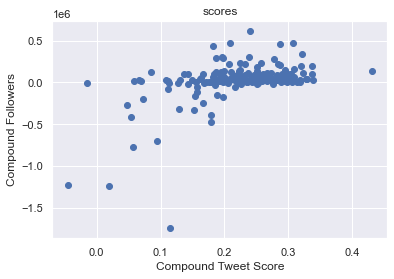

In [121]:
plt.scatter(df_merged_gme['Compound Tweet Score'], df_merged_gme['Compound Followers'])
plt.title('scores')
plt.xlabel('Compound Tweet Score')
plt.ylabel('Compound Followers')
plt.show();

In [122]:
df_merged_gme

,Volume,Closing Differences,Percent Change,Tweet Id,Followers Count,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Negative Tweet Score,Compound Tweet Score,Compound Followers,Percent Change Trend,Closing Price Trend
Datetime,,,,,,,,,,,,,,
2021-01-01,1.002250e+07,0.120001,-9.210526,1.344979e+18,62086.130963,0.949696,10.635733,1.125759,0.160056,0.062647,0.269853,34364.360617,Negative_Trend,Positive_Trend
2021-01-02,1.002250e+07,0.120001,-9.210526,1.345359e+18,101770.186290,68.192742,57.750000,3.098387,0.161263,0.052595,0.327639,44249.406987,Negative_Trend,Positive_Trend
2021-01-03,1.002250e+07,0.120001,-9.210526,1.345734e+18,101301.291471,1.685695,25.027535,2.658831,0.156467,0.064760,0.273965,25993.188582,Negative_Trend,Positive_Trend
2021-01-04,1.002250e+07,0.120001,-9.210526,1.346104e+18,93561.129870,1.246163,15.107438,2.065525,0.149979,0.058672,0.258476,40531.963996,Negative_Trend,Positive_Trend
2021-01-05,4.961500e+06,0.120001,0.115276,1.346466e+18,29511.414783,0.873913,9.100870,0.984348,0.162212,0.057242,0.313195,8266.200468,Positive_Trend,Positive_Trend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,1.008827e+07,-0.620000,-1.083174,1.408885e+18,243348.953474,4.097281,45.287009,3.056193,0.162093,0.072709,0.295099,143663.299006,Negative_Trend,Negative_Trend
2021-06-27,7.483833e+06,1.560003,-0.068214,1.409257e+18,233403.859638,28.293200,299.946974,7.606363,0.152480,0.071153,0.225888,73539.994403,Negative_Trend,Positive_Trend
2021-06-28,4.879400e+06,3.740005,0.946746,1.409620e+18,405717.609408,2.689218,23.022199,1.616808,0.177967,0.069434,0.320421,193374.560155,Positive_Trend,Positive_Trend


In [55]:
from collections import Counter

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

## AAPL

# Dealing with Imbalances

In [34]:
from imblearn.over_sampling import SMOTE

In [35]:
sampler = SMOTE(random_state=42)

# Modeling

## GME

#### Train/Test Split

In [277]:
X = df_merged_gme.loc[:'2021-4-6']
y = df_merged_gme['Percent Change Trend'].loc[:'2021-4-6']

In [258]:
X['PCT Label'] = X['Percent Change Trend'].shift(-6)
X['CPT Label'] = X['Closing Price Trend'].shift(-6)

C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/3046459647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PCT Label'] = X['Percent Change Trend'].shift(-6)
C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/3046459647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['CPT Label'] = X['Closing Price Trend'].shift(-6)


In [250]:
X['PCT Label'] = X['Percent Change Trend'].shift(-5)
X['CPT Label'] = X['Closing Price Trend'].shift(-5)

C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/1319375174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PCT Label'] = X['Percent Change Trend'].shift(-5)
C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/1319375174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['CPT Label'] = X['Closing Price Trend'].shift(-5)


In [243]:
X['PCT Label'] = X['Percent Change Trend'].shift(-4)
X['CPT Label'] = X['Closing Price Trend'].shift(-4)

C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/91027942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PCT Label'] = X['Percent Change Trend'].shift(-4)
C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/91027942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['CPT Label'] = X['Closing Price Trend'].shift(-4)


In [278]:
X['PCT Label'] = X['Percent Change Trend'].shift(-3)
X['CPT Label'] = X['Closing Price Trend'].shift(-3)

C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/797088856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PCT Label'] = X['Percent Change Trend'].shift(-3)
C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/797088856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['CPT Label'] = X['Closing Price Trend'].shift(-3)


In [227]:
X['PCT Label'] = X['Percent Change Trend'].shift(-2)
X['CPT Label'] = X['Closing Price Trend'].shift(-2)

C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/70159314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PCT Label'] = X['Percent Change Trend'].shift(-2)
C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/70159314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['CPT Label'] = X['Closing Price Trend'].shift(-2)


In [218]:
X['PCT Label'] = X['Percent Change Trend'].shift(-1)
X['CPT Label'] = X['Closing Price Trend'].shift(-1)

C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/3742446581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PCT Label'] = X['Percent Change Trend'].shift(-1)
C:\Users\Daanish\AppData\Local\Temp/ipykernel_4764/3742446581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['CPT Label'] = X['Closing Price Trend'].shift(-1)


In [279]:
y = X['PCT Label'].dropna()

In [260]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.dropna(), y, test_size=0.2, random_state=42)

In [198]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X_train, y_train)

#### Support Vector Machine (Baseline)

In [380]:
transformer_svm = ColumnTransformer([
    ('scaler', StandardScaler(), ['Followers Count', 'Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers'])
])

In [381]:
pipe_svm = Pipeline([
    ('ohe', transformer_svm),
    ('svm', svm.SVC(kernel='poly'))
])

In [384]:
pipe_svm_fit = pipe_svm.fit(X[['Followers Count', 'Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers']].loc[:'2021-4-3'], y)

In [385]:
pipe_svm_fit.score(X_testo, y_testo)

0.6129032258064516

In [378]:
pipe_svm_fit.classes_

array(['Negative_Trend', 'Positive_Trend'], dtype=object)

In [379]:
pipe_svm_fit.feature_names_in_

array(['Followers Count', 'Retweet Count', 'Likes Count', 'Reply Count',
       'Positive Tweet Score', 'Negative Tweet Score',
       'Neutral Tweet Score', 'Compound Followers', 'Volume'],
      dtype=object)

#### Random Forest Classifier (Baseline)

In [290]:
y_testo = df_merged_gme.loc["2021-4-6":"2021-5-9"]['PCT Label'].shift(-3).dropna()

In [296]:
X_testo = df_merged_gme.loc["2021-4-6":"2021-5-6"].drop(['PCT Label', 'CPT Label'], axis=1)

In [297]:
X_testo

,Volume,Closing Differences,Percent Change,Tweet Id,Followers Count,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Neutral Tweet Score,Negative Tweet Score,Compound Tweet Score,Compound Followers,Percent Change Trend,Closing Price Trend
Datetime,,,,,,,,,,,,,,,
2021-04-06,6.218300e+06,-2.449997,-0.383352,1.379546e+18,4.606260e+04,1.435742,12.407612,1.309983,0.135548,0.792430,0.072039,0.249122,7252.298951,Negative_Trend,Negative_Trend
2021-04-07,4.768300e+06,-6.529999,-2.865408,1.379904e+18,1.749696e+05,3.107615,35.748746,2.208390,0.165514,0.770521,0.063975,0.293148,77247.872900,Negative_Trend,Negative_Trend
2021-04-08,1.004740e+07,-7.710007,-8.403276,1.380276e+18,7.986348e+05,3.537443,50.720548,6.566667,0.173219,0.761284,0.065450,0.286585,460692.027239,Negative_Trend,Negative_Trend
2021-04-09,9.462400e+06,-11.899994,-6.682379,1.380633e+18,4.094352e+05,4.622445,46.001115,4.793757,0.143979,0.771456,0.084568,0.166755,104136.467043,Negative_Trend,Negative_Trend
2021-04-10,1.186947e+07,-13.689997,-8.043139,1.380958e+18,1.707890e+05,2.297376,20.102527,2.086978,0.135708,0.800628,0.063683,0.240049,38576.458571,Negative_Trend,Negative_Trend
2021-04-11,1.427653e+07,-15.480001,-9.403900,1.381332e+18,2.284892e+04,3.083829,48.101677,2.062196,0.160271,0.779225,0.060501,0.318485,8768.075056,Negative_Trend,Negative_Trend
2021-04-12,1.668360e+07,-17.270004,-10.764660,1.381724e+18,1.014666e+06,16.721827,73.409645,4.025381,0.145604,0.782375,0.072025,0.209973,126763.857919,Negative_Trend,Negative_Trend
2021-04-13,6.806900e+06,-0.099991,-0.627290,1.382082e+18,7.249978e+04,4.128680,34.629226,2.191385,0.152661,0.777448,0.069901,0.247932,28645.620404,Negative_Trend,Negative_Trend
2021-04-14,2.113810e+07,25.539993,15.992192,1.382454e+18,5.534159e+05,5.952555,52.105839,1.906934,0.163355,0.771861,0.064788,0.257537,231979.366698,Positive_Trend,Positive_Trend


In [280]:
transformer_rfc = ColumnTransformer([
    ('scaler', StandardScaler(), ['Followers Count', 'Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers', 'Volume'])
])

In [281]:
pipe_rfc = Pipeline([
    ('ohe scaler', transformer_rfc),
    ('randomforest', GridSearchCV(RandomForestClassifier(),
                                  param_grid={},
                                  verbose=3,
                                  n_jobs=4))
])

In [282]:
pipe_rfc_fit = pipe_rfc.fit(X.dropna(), y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [275]:
df_merged_gme.loc["2021-4-6":"2021-5-6"]

,Volume,Closing Differences,Percent Change,Tweet Id,Followers Count,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Neutral Tweet Score,Negative Tweet Score,Compound Tweet Score,Compound Followers,Percent Change Trend,Closing Price Trend,PCT Label,CPT Label
Datetime,,,,,,,,,,,,,,,,,
2021-04-06,6.218300e+06,-2.449997,-0.383352,1.379546e+18,4.606260e+04,1.435742,12.407612,1.309983,0.135548,0.792430,0.072039,0.249122,7252.298951,Negative_Trend,Negative_Trend,NaN,NaN
2021-04-07,4.768300e+06,-6.529999,-2.865408,1.379904e+18,1.749696e+05,3.107615,35.748746,2.208390,0.165514,0.770521,0.063975,0.293148,77247.872900,Negative_Trend,Negative_Trend,Negative_Trend,Negative_Trend
2021-04-08,1.004740e+07,-7.710007,-8.403276,1.380276e+18,7.986348e+05,3.537443,50.720548,6.566667,0.173219,0.761284,0.065450,0.286585,460692.027239,Negative_Trend,Negative_Trend,Positive_Trend,Positive_Trend
2021-04-09,9.462400e+06,-11.899994,-6.682379,1.380633e+18,4.094352e+05,4.622445,46.001115,4.793757,0.143979,0.771456,0.084568,0.166755,104136.467043,Negative_Trend,Negative_Trend,Negative_Trend,Negative_Trend
2021-04-10,1.186947e+07,-13.689997,-8.043139,1.380958e+18,1.707890e+05,2.297376,20.102527,2.086978,0.135708,0.800628,0.063683,0.240049,38576.458571,Negative_Trend,Negative_Trend,Negative_Trend,Negative_Trend
2021-04-11,1.427653e+07,-15.480001,-9.403900,1.381332e+18,2.284892e+04,3.083829,48.101677,2.062196,0.160271,0.779225,0.060501,0.318485,8768.075056,Negative_Trend,Negative_Trend,Negative_Trend,Positive_Trend
2021-04-12,1.668360e+07,-17.270004,-10.764660,1.381724e+18,1.014666e+06,16.721827,73.409645,4.025381,0.145604,0.782375,0.072025,0.209973,126763.857919,Negative_Trend,Negative_Trend,Negative_Trend,Positive_Trend
2021-04-13,6.806900e+06,-0.099991,-0.627290,1.382082e+18,7.249978e+04,4.128680,34.629226,2.191385,0.152661,0.777448,0.069901,0.247932,28645.620404,Negative_Trend,Negative_Trend,Negative_Trend,Positive_Trend
2021-04-14,2.113810e+07,25.539993,15.992192,1.382454e+18,5.534159e+05,5.952555,52.105839,1.906934,0.163355,0.771861,0.064788,0.257537,231979.366698,Positive_Trend,Positive_Trend,Negative_Trend,Negative_Trend


In [273]:
df

,Volume,Closing Differences,Percent Change,Tweet Id,Followers Count,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Neutral Tweet Score,Negative Tweet Score,Compound Tweet Score,Compound Followers,Percent Change Trend,Closing Price Trend,PCT Label,CPT Label
Datetime,,,,,,,,,,,,,,,,,
2021-01-01,10022500.0,0.120001,-9.210526,1.344979e+18,62086.130963,0.949696,10.635733,1.125759,0.160056,0.777298,0.062647,0.269853,34364.360617,Negative_Trend,Positive_Trend,Negative_Trend,Positive_Trend
2021-01-02,10022500.0,0.120001,-9.210526,1.345359e+18,101770.186290,68.192742,57.750000,3.098387,0.161263,0.786141,0.052595,0.327639,44249.406987,Negative_Trend,Positive_Trend,Positive_Trend,Positive_Trend
2021-01-03,10022500.0,0.120001,-9.210526,1.345734e+18,101301.291471,1.685695,25.027535,2.658831,0.156467,0.778779,0.064760,0.273965,25993.188582,Negative_Trend,Positive_Trend,Positive_Trend,Positive_Trend
2021-01-04,10022500.0,0.120001,-9.210526,1.346104e+18,93561.129870,1.246163,15.107438,2.065525,0.149979,0.791347,0.058672,0.258476,40531.963996,Negative_Trend,Positive_Trend,Negative_Trend,Negative_Trend
2021-01-05,4961500.0,0.120001,0.115276,1.346466e+18,29511.414783,0.873913,9.100870,0.984348,0.162212,0.780561,0.057242,0.313195,8266.200468,Positive_Trend,Positive_Trend,Negative_Trend,Negative_Trend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-02,10518350.0,0.097492,1.591023,1.378073e+18,161116.231076,4.191733,34.119522,2.113048,0.144751,0.773458,0.081795,0.252129,71315.322294,Positive_Trend,Positive_Trend,Positive_Trend,Negative_Trend
2021-04-03,11702400.0,-1.435005,4.169843,1.378430e+18,45834.822128,2.941239,24.801482,2.030704,0.157101,0.771647,0.071274,0.317955,25936.872098,Positive_Trend,Negative_Trend,Negative_Trend,Negative_Trend
2021-04-04,12886450.0,-2.967503,6.748664,1.378781e+18,72166.222334,1.385815,13.961268,1.127767,0.152070,0.776227,0.071702,0.277361,25383.782364,Positive_Trend,Negative_Trend,NaN,NaN


In [300]:
pipe_rfc_fit.predict_proba(df_merged_gme.loc["2021-4-6":"2021-5-6"])

array([[0.79, 0.21],
       [0.28, 0.72],
       [0.31, 0.69],
       [0.63, 0.37],
       [0.49, 0.51],
       [0.56, 0.44],
       [0.48, 0.52],
       [0.41, 0.59],
       [0.45, 0.55],
       [0.68, 0.32],
       [0.4 , 0.6 ],
       [0.49, 0.51],
       [0.7 , 0.3 ],
       [0.54, 0.46],
       [0.62, 0.38],
       [0.35, 0.65],
       [0.28, 0.72],
       [0.38, 0.62],
       [0.31, 0.69],
       [0.43, 0.57],
       [0.18, 0.82],
       [0.38, 0.62],
       [0.64, 0.36],
       [0.31, 0.69],
       [0.69, 0.31],
       [0.55, 0.45],
       [0.38, 0.62],
       [0.44, 0.56],
       [0.41, 0.59],
       [0.29, 0.71],
       [0.58, 0.42]])

In [301]:
y_testo

Datetime
2021-04-06    Negative_Trend
2021-04-07    Negative_Trend
2021-04-08    Negative_Trend
2021-04-09    Negative_Trend
2021-04-10    Negative_Trend
2021-04-11    Negative_Trend
2021-04-12    Positive_Trend
2021-04-13    Negative_Trend
2021-04-14    Positive_Trend
2021-04-15    Positive_Trend
2021-04-16    Positive_Trend
2021-04-17    Positive_Trend
2021-04-18    Negative_Trend
2021-04-19    Positive_Trend
2021-04-20    Negative_Trend
2021-04-21    Negative_Trend
2021-04-22    Negative_Trend
2021-04-23    Negative_Trend
2021-04-24    Negative_Trend
2021-04-25    Positive_Trend
2021-04-26    Negative_Trend
2021-04-27    Positive_Trend
2021-04-28    Positive_Trend
2021-04-29    Negative_Trend
2021-04-30    Negative_Trend
2021-05-01    Negative_Trend
2021-05-02    Positive_Trend
2021-05-03    Negative_Trend
2021-05-04    Positive_Trend
2021-05-05    Negative_Trend
2021-05-06    Positive_Trend
Name: PCT Label, dtype: object

In [302]:
from sklearn.metrics import confusion_matrix

In [303]:
confusion_matrix(y_true=y_testo, y_pred=pipe_rfc_fit.predict(df_merged_gme.loc["2021-4-6":"2021-5-6"]))

array([[ 7, 12],
       [ 4,  8]], dtype=int64)

In [298]:
# Shift of -3 REAL
model_evaluation(pipe_rfc_fit, X_testo, y_testo, positive_label='Positive_Trend')

{'accuracy': 0.4839,
 'precision': 0.4,
 'recall': 0.6667,
 'area under precision-recall curve': 0.3088,
 'f1 score': 0.5}

In [276]:
# Shift of -3
model_evaluation(pipe_rfc_fit, df_merged_gme.loc["2021-4-6":"2021-5-6"], df_merged_gme.loc["2021-4-6":"2021-5-6"][, positive_label='Positive_Trend')

{'accuracy': 0.7222,
 'precision': 0.6667,
 'recall': 0.3333,
 'area under precision-recall curve': 0.6039,
 'f1 score': 0.4444}

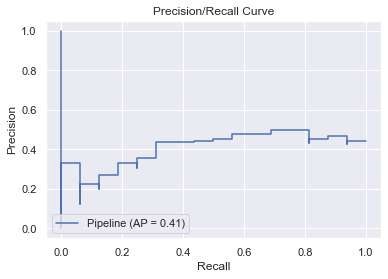

In [151]:
PrecisionRecallDisplay.from_estimator(pipe_rfc_fit, X_test, y_test)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve');

#### Logistic Regression (Baseline)

In [337]:
transformer_logit = ColumnTransformer([
    ('scaler', StandardScaler(), ['Followers Count', 'Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers', 'Volume'])
])

In [338]:
pipe_logit = Pipeline([
    ('ohe', transformer_logit),
    ('logit', LogisticRegression())
])

In [340]:
y

Datetime
2021-01-01    Negative_Trend
2021-01-02    Positive_Trend
2021-01-03    Positive_Trend
2021-01-04    Negative_Trend
2021-01-05    Negative_Trend
                   ...      
2021-03-30    Positive_Trend
2021-03-31    Positive_Trend
2021-04-01    Positive_Trend
2021-04-02    Positive_Trend
2021-04-03    Negative_Trend
Name: PCT Label, Length: 93, dtype: object

In [343]:
pipe_logit_fit = pipe_logit.fit(X.dropna(), y)

In [344]:
model_evaluation(pipe_logit, X_testo, y_testo, positive_label='Positive_Trend')

{'accuracy': 0.4194,
 'precision': 0.3125,
 'recall': 0.4167,
 'area under precision-recall curve': 0.371,
 'f1 score': 0.3571}

In [345]:
pipe_logit_fit.predict_proba(X_test)

array([[0.38150739, 0.61849261],
       [0.84071646, 0.15928354],
       [0.47308669, 0.52691331],
       [0.59166055, 0.40833945],
       [0.4394202 , 0.5605798 ],
       [0.90766538, 0.09233462],
       [0.38408909, 0.61591091],
       [0.58019247, 0.41980753],
       [0.57084401, 0.42915599],
       [0.51744713, 0.48255287],
       [0.70100076, 0.29899924],
       [0.84054068, 0.15945932],
       [0.54794139, 0.45205861],
       [0.52383588, 0.47616412],
       [0.54014473, 0.45985527],
       [0.39809021, 0.60190979],
       [0.16523788, 0.83476212],
       [0.83071609, 0.16928391]])